# Codespaces

Copilot codespaces is free for an edu account. It allows you to "upload" hints and source material. The [`hep-programming-hints`](https://github.com/gordonwatts/hep-programming-hints) repo was used. As the code had trouble running various things, that repo was updated (without re-running previously run questions). GPT 4.1 was used as the model. The [code space can be found here](https://github.com/copilot/spaces/gordonwatts/1) (this might not be accessible to anyone but me).

Note that when testing this was writing Release 25 code, and that was not yet released for ServiceX.

## Question 1: ETmiss

Prompt: `Plot the ETmiss of all events in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697`

[Codespace Query]()

Modifications:

* It mistakenly things you can access `met()` directly from the container rather than fetching the first MET object.
    * Added code to the hints database that details how to get at the missing et (re-running the query and it did it correctly).
* Removed the `ak.flatten`.
* Added the backend since `atlasr25` isn't on production yet.
* Added a `plt.show()` (which is ok - the instructions explicitly tell it not to do that).

Output()

c:\Users\gordo\Code\llms\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


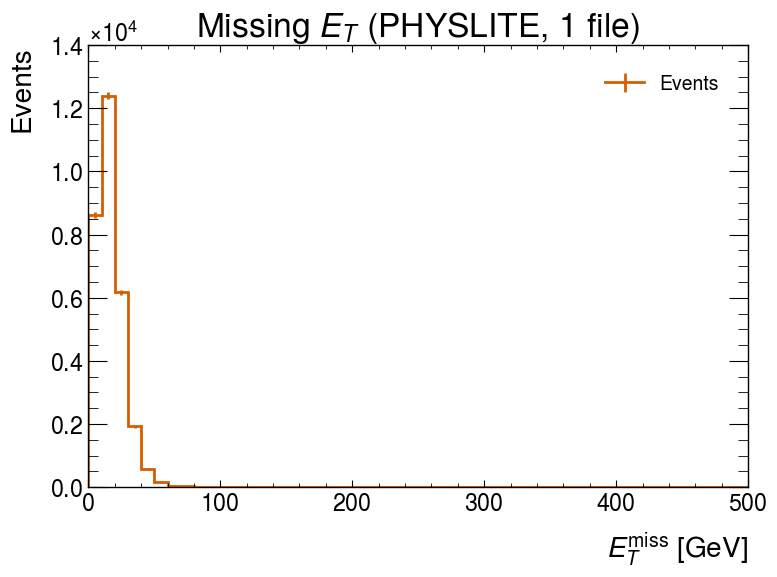

Saved ETmiss histogram as etmiss_hist.png


<Figure size 800x600 with 0 Axes>

In [ ]:
import awkward as ak
import vector
import matplotlib.pyplot as plt
import mplhep as hep
from hist import Hist

from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset

# Register vector behaviors for awkward arrays (not strictly needed for ETmiss, but good practice)
vector.register_awkward()

# Step 1: Build the query to get ETmiss for each event
base_query = FuncADLQueryPHYSLITE()

# In PHYSLITE, MET is stored as a sequence per event; we want the first (and only) one
etmiss_query = base_query.Select(lambda e: e.MissingET().First()).Select(
    lambda met: {"etmiss": met.met() / 1000.0}
)  # GeV

# Step 2: Deliver the data from ServiceX (use only 1 file for quick test; remove NFiles for full dataset)
ds_name = "mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697"
result = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="etmiss_fetch",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,  # Remove or increase for full production
                    Query=etmiss_query,
                )
            ]
        ),
    )
)

etmiss = result["etmiss_fetch"].etmiss  # awkward array of ETmiss per event

# Step 3: Flatten and convert to numpy for histogramming
etmiss_flat = ak.to_numpy(etmiss)

# Step 4: Make the histogram
h = Hist.new.Reg(
    50, 0, 500, name="etmiss", label=r"$E_{T}^{\mathrm{miss}}$ [GeV]"
).Int64()
h.fill(etmiss=etmiss_flat)

# Step 5: Plot with mplhep
plt.style.use(hep.style.ATLAS)
fig, ax = plt.subplots()
h.plot(ax=ax, histtype="step", linewidth=2, label="Events")
ax.set_xlabel(r"$E_{T}^{\mathrm{miss}}$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("Missing $E_T$ (PHYSLITE, 1 file)")
ax.legend()
plt.tight_layout()
plt.show()
plt.savefig("etmiss_hist.png")
print("Saved ETmiss histogram as etmiss_hist.png")

## Question 2: All Jets

Prompt: `Plot the jet pT for all jets in mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697`

Using this [codespace](https://github.com/copilot/spaces/gordonwatts/1). Here is the [query](https://github.com/copilot/c/1aab4eb2-2ee9-462f-a2d7-0cb18a099e47).

Modifications made to the raw code below:

* Remove the `ak.flatten` around the result (the `SelectMany` already does that). Initial attempts to alter the hints did not fix this problem.
* Added the backend since `atlasr25` isn't on production yet.
* Added a `plt.show()` (which is ok - the instructions explicitly tell it not to do that).

Output()

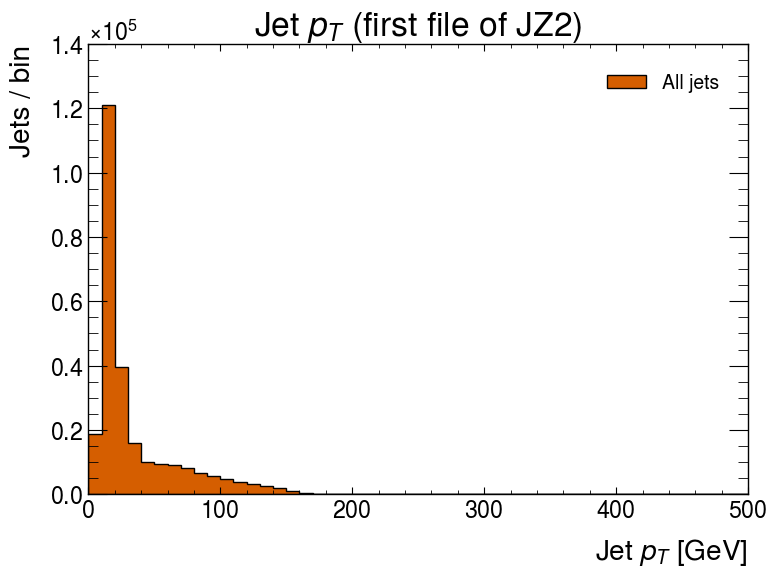

In [2]:
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
from hist import Hist
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset

# 1. Build the query for jet pt (in GeV) from the dataset
base_query = FuncADLQueryPHYSLITE()
jet_pts_query = (
    base_query
    .SelectMany(lambda evt: evt.Jets())
    .Select(lambda jet: {
        "jet_pt": jet.pt() / 1000.0,  # GeV
    })
)

ds_name = "mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697"

# 2. Fetch awkward array from ServiceX (limit to 1 file for speed)
all_jet_pts = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="jet_pt_fetch",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,
                    Query=jet_pts_query,
                )
            ]
        ),
    )
)

# 3. Extract jet pT values
jet_pt = all_jet_pts["jet_pt_fetch"].jet_pt

# 4. Build the histogram for jet pT (0 to 500 GeV, 50 bins)
hist_jet_pt = (
    Hist.new
        .Reg(50, 0, 500, name="jet_pt", label="Jet $p_T$ [GeV]")
        .Int64()
)
hist_jet_pt.fill(jet_pt=jet_pt)

# 5. Plot and save
plt.style.use(hep.style.ATLAS)
hist_jet_pt.plot(histtype="fill", linewidth=1, edgecolor="black", label="All jets")
plt.xlabel("Jet $p_T$ [GeV]")
plt.ylabel("Jets / bin")
plt.title("Jet $p_T$ (first file of JZ2)")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("jet_pt.png")
plt.close()

## 3. Central jets

Prompt: `Plot the pT of jets with |η| < 1 in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697`

[Codespace Query](https://github.com/copilot/c/65bcb7d2-a047-47a9-9755-2194dee727b2)

Modifications:

- Remove the `ak.flatten`.
- note: it added `import vector` even though it didn't need it.
- Changed the servicex backend
- Add a `plt.show()`.

Output()

c:\Users\gordo\Code\llms\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


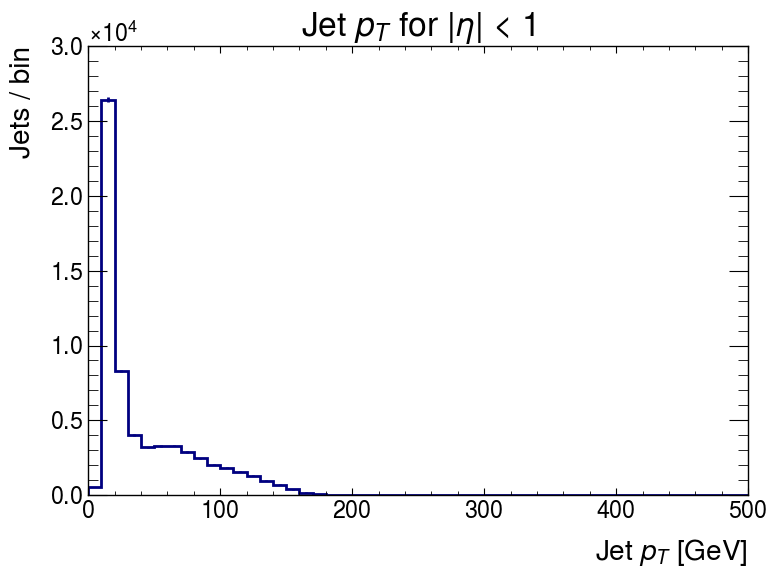

In [ ]:
import awkward as ak
import vector
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset
from hist import Hist
import matplotlib.pyplot as plt
import mplhep as hep

# Register vector behaviors for awkward arrays
vector.register_awkward()

# Define the dataset name
ds_name = "mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697"

# Define the query: get jets with |eta| < 1 and fetch their pt (in GeV)
base_query = FuncADLQueryPHYSLITE()
jet_query = (
    base_query.SelectMany(lambda evt: evt.Jets())
    .Where(lambda jet: abs(jet.eta()) < 1.0)
    .Select(
        lambda jet: {
            "pt": jet.pt() / 1000.0,  # Convert to GeV
        }
    )
)

# Deliver the query and fetch the results (use only 1 file for speed in demo; remove NFiles to run on all)
result = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="jet_pt_eta_lt1",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,
                    Query=jet_query,
                )
            ]
        ),
    )
)

# Extract pt awkward array
jet_pts = result["jet_pt_eta_lt1"].pt

# Plot histogram with Hist
h = Hist.new.Reg(50, 0, 500, name="pt", label="Jet $p_T$ [GeV]").Int64()
h.fill(pt=jet_pts)

plt.style.use(hep.style.ATLAS)
h.plot(histtype="step", linewidth=2, color="navy")
plt.xlabel(r"Jet $p_T$ [GeV]")
plt.ylabel("Jets / bin")
plt.title(r"Jet $p_T$ for |$\eta$| < 1")
plt.tight_layout()
plt.show()
plt.savefig("jet_pt_eta_lt1.png")
plt.close()

## 4. Missing ET of events with jets

Prompt: `Plot the ETmiss of events that have at least two jets with pT > 40 GeV in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697.`

[Codespace Query]()

Modifications:

- note: it added `import vector` even though it didn't need it.
- Changed the servicex backend
- Add a `plt.show()`.

Output()

c:\Users\gordo\Code\llms\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


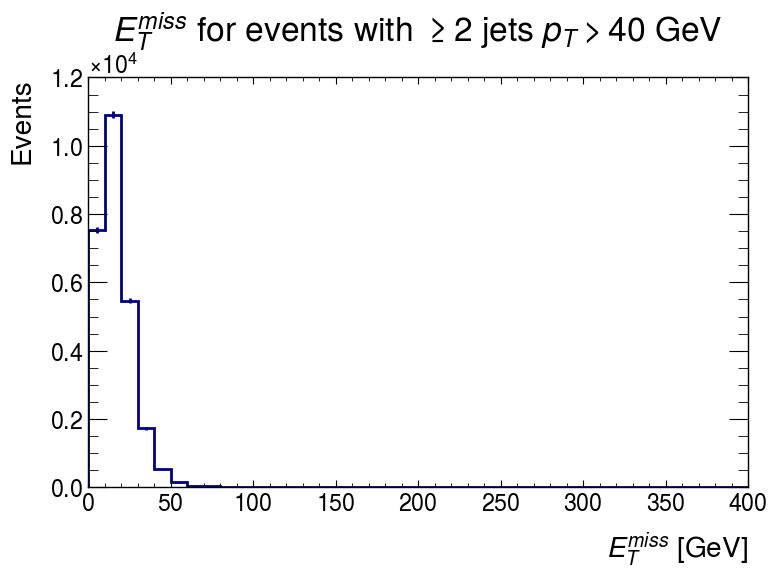

Saved plot to etmiss_hist.png


<Figure size 800x600 with 0 Axes>

In [ ]:
import awkward as ak
import vector
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset
from hist import Hist
import matplotlib.pyplot as plt
import mplhep as hep

# Register vector behaviors for awkward arrays
vector.register_awkward()

# Dataset name
ds_name = "mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697"

# Build the query: select events with >=2 jets with pt>40 GeV, get ETmiss
query = (
    FuncADLQueryPHYSLITE()
    .Where(lambda e: e.Jets().Where(lambda j: j.pt() / 1000.0 > 40.0).Count() >= 2)
    .Select(
        lambda e: {
            "met": e.MissingET().First().met() / 1000.0,  # ETmiss in GeV
        }
    )
)

# Deliver the data (for full dataset, remove NFiles)
result = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="etmiss_jet",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,  # for quick test; set to None or remove for full statistics
                    Query=query,
                )
            ]
        ),
    )
)

# Extract awkward array of ETmiss
etmiss = result["etmiss_jet"].met

# Make ETmiss histogram
h = Hist.new.Reg(40, 0, 400, name="etmiss", label="E_{T}^{miss} [GeV]").Double()
h.fill(etmiss=ak.to_numpy(etmiss))

# Plot with mplhep style
plt.style.use(hep.style.ATLAS)
fig, ax = plt.subplots()
h.plot(histtype="step", linewidth=2, ax=ax, color="navy")
ax.set_xlabel(r"$E_{T}^{miss}$ [GeV]")
ax.set_ylabel("Events")
ax.set_title(r"$E_{T}^{miss}$ for events with $\geq$2 jets $p_T>40$ GeV")
plt.tight_layout()
plt.show()
plt.savefig("etmiss_hist.png")
print("Saved plot to etmiss_hist.png")

## 5. Opposite sign pair of muons.

Prompt: `Plot the ETmiss of events that have an opposite-charge muon pair with an invariant mass between 60 and 120 GeV in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.513109.MGPy8EG_Zmumu_FxFx3jHT2bias_SW_CFilterBVeto.deriv.DAOD_PHYSLITE.e8514_e8528_s4162_s4114_r14622_r14663_p6697.`

[Codespace Query](https://github.com/copilot/c/3636153e-fdbd-43c2-bd13-9fc0280a62fa)

Modifications:

- Changed the servicex backend
- Add a `plt.show()`.
- It fetched the muon mass even though it didn't need it (it could have been a constant).

In [ ]:
import awkward as ak
import vector
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset

# Register awkward behaviors for Lorentz vectors
vector.register_awkward()

# Dataset name
ds_name = "mc23_13p6TeV:mc23_13p6TeV.513109.MGPy8EG_Zmumu_FxFx3jHT2bias_SW_CFilterBVeto.deriv.DAOD_PHYSLITE.e8514_e8528_s4162_s4114_r14622_r14663_p6697"

# Build query: for each event, select MET, and all muons' kinematics and charges
base_query = FuncADLQueryPHYSLITE()
query = base_query.Select(
    lambda e: {
        "met": e.MissingET().First().met() / 1000.0,  # MET in GeV
        "mu_pt": e.Muons().Select(lambda mu: mu.pt() / 1000.0),  # pt in GeV
        "mu_eta": e.Muons().Select(lambda mu: mu.eta()),
        "mu_phi": e.Muons().Select(lambda mu: mu.phi()),
        "mu_mass": e.Muons().Select(lambda mu: mu.m()),  # mass in MeV
        "mu_charge": e.Muons().Select(lambda mu: mu.charge()),
    }
)

# Fetch data (1 file for quick test; remove NFiles to run over all)
result = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="evt_muons_met",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,
                    Query=query,
                )
            ]
        ),
    )
)

events = result["evt_muons_met"]

# Build Lorentz vectors for muons
muons = ak.zip(
    {
        "pt": events["mu_pt"],
        "eta": events["mu_eta"],
        "phi": events["mu_phi"],
        # Convert mass from MeV to GeV for consistency
        "mass": events["mu_mass"] / 1000.0,
    },
    with_name="Momentum4D",
)
mu_charge = events["mu_charge"]

# Find all unique pairs of muons in each event
pairs = ak.combinations(muons, 2, fields=["m1", "m2"], axis=1)
charge_pairs = ak.combinations(mu_charge, 2, fields=["q1", "q2"], axis=1)

# Opposite-charge mask
opp_charge = (charge_pairs["q1"] * charge_pairs["q2"]) < 0

# Invariant mass of each pair
pair_mass = (pairs["m1"] + pairs["m2"]).mass

# Mass window mask (60 < mass < 120 GeV)
mass_mask = (pair_mass > 60.0) & (pair_mass < 120.0)

# Both cuts: opposite charge and in mass window
pair_mask = opp_charge & mass_mask

# For each event, does there exist at least one pair passing both conditions?
has_good_pair = ak.any(pair_mask, axis=1)

# Select MET for events with at least one good pair
met_selected = events["met"][has_good_pair]

# -- Plotting --
import matplotlib.pyplot as plt
import hist
import mplhep as hep

plt.style.use(hep.style.ATLAS)

# Define histogram: 40 bins, 0-400 GeV
h = hist.Hist.new.Reg(40, 0, 400, name="met", label="$E_{T}^{miss}$ [GeV]").Double()

h.fill(met=ak.to_numpy(met_selected))

h.plot(histtype="step", linewidth=2, label=r"$E_{T}^{miss}$")
plt.xlabel(r"$E_{T}^{miss}$ [GeV]")
plt.ylabel("Events")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("etmiss_opposite_charge_muonpair.png")

## 6. $tt$ all-jets invariant mass

Prompt: For events with at least three jets, plot the pT of the trijet four-momentum that has the invariant mass closest to 172.5 GeV in each event and plot the maximum b-tagging discriminant value among the jets in this trijet in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad.deriv.DAOD_PHYSLITE.e8514_s4369_r16083_p6697.

Modifications:

**version 1**:

* First version didn't know how to get at the b-tagging information. Rather, it did the following: `"btag": jets.Select(lambda j: j.btag_DL1dv01())` - which makes so much more sense.
    * ATLAS b-tagging involves all sorts of tools - it isn't trivial - so will experiment with teaching the LLM this in version 2. But it would have been amazing if it knew how to get the discriminant.
* It made a 2D plot rather than a 2 1D plots.
    * Updated master prompt to make sure multiple plots were acceptable.
* It ran this with 10 files, not 1 file.
    - Tried to be more explicit about using NFiles=1 in the instructions.
* Large numbers of jets, etc., that came back meant large memory and large CPU time.
* It tried to use something called `ak.arrange`. Replacing it with `np.arrange` lead to some more "bad" behavior further down the way.

**version 2**:

* Even with updated files, GPT 4.1 didn't understand what it needed to do for the tool. The OpenAI 4o-mini model seemed to work.
* Wrote `from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE, Jet_v1` - but for `Jet_v1` it really needed `from func_adl_servicex_xaodr25.xAOD.jet_v1 import Jet_v1`.
* Wrote `from func_adl.common import ObjectStream` - didn't need the `common`.
* Wrote `from func_adl.types import func_adl_callable` - didn't need the `types`
* Wrote `best_tri = tri_sum[best_idx]` which caused a slicing error.
    - The issue is subtle and has to do with the day that slicing works in awkward. What we need is:
    - `best_idx = ak.singletons(ak.argmin(delta, axis=1))`
    - `best_tri = ak.flatten(tri_sum[best_idx])`
    - `best_trip = ak.flatten(triplets[best_idx])`
    - The reason is that the argmin has to be able to deal with the empty list, so it puts a None in there, which means the return type for `argmin` is `?int64` - and that doesn't work with the slicing. So, `ak.singletons` will create a `[]` for each `None`, and then you can do the slicing properly. Finally, the `ak.flatten` gets rid of the extra indirection that `ak.singletons` adds.
    - Explaining this to the LLM is going to be complex!
* Tried to use `ak.stack`, but `np.stack` works fine.
* Wrote the following: `fourvecs = ak.zip({"pt": pts, "eta": etas, "phi": phis, "mass": ms}, with_name="Momentum4D"); jets_rec = ak.zip({"vec": fourvecs, "btag": btags})` It wrote that in two lines, it didn't need to do that - it could have done that in one line. And it adds another level of indirection (which it seems to track).
* Gets the limits for the b-tagging discriminant incorrect, assuming they are 0 to 1, but should be -10 to 15.

**Version 3**:
This [commit](https://github.com/gordonwatts/hep-programming-hints/commit/d2616d397bbe8411c5d030082acfbc2e7dbf48d6) updated the hints files to address the above comments.

* Still using `o4-mini`.
* Observation: the leaf names weren't the same each time it runs, which can re-generate a servicex query.
* Observation: it brings back all the data (all jets), which can be very expensive - and useless. It needs to do jet cuts.
* Observation: Fixing confusions in the hints files often means totally rewriting a section to be more clear.
* Still used `ak.stack` rather than `np.stack`! Several updates to our hints didn't fix this.
* Got the order before the `np.stack` incorrect - didn't pair things down to a 2D array first.
* Made a 2D plot (after not doing it for many iterations).
* Observation: At one point or another o4-mini got all the bits right (other than `ak.stack`), but it never got them all right at the same time.

Output()

c:\Users\gordo\Code\llms\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
c:\Users\gordo\Code\llms\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


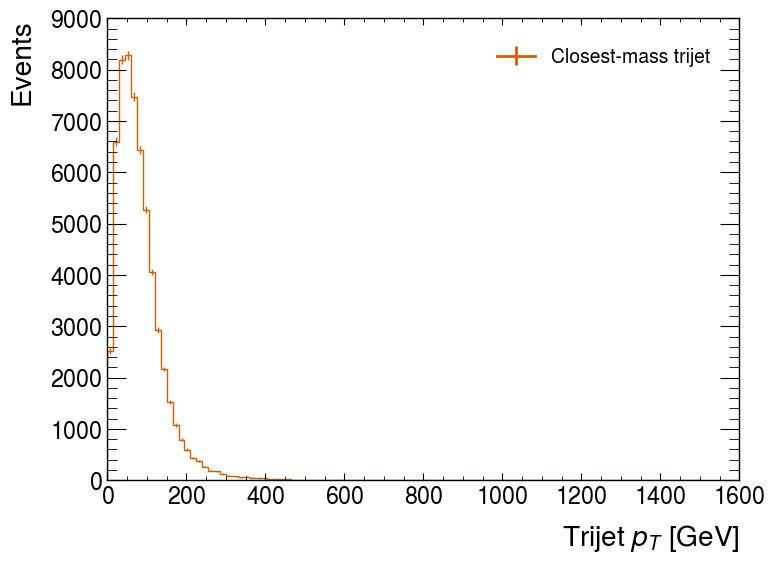

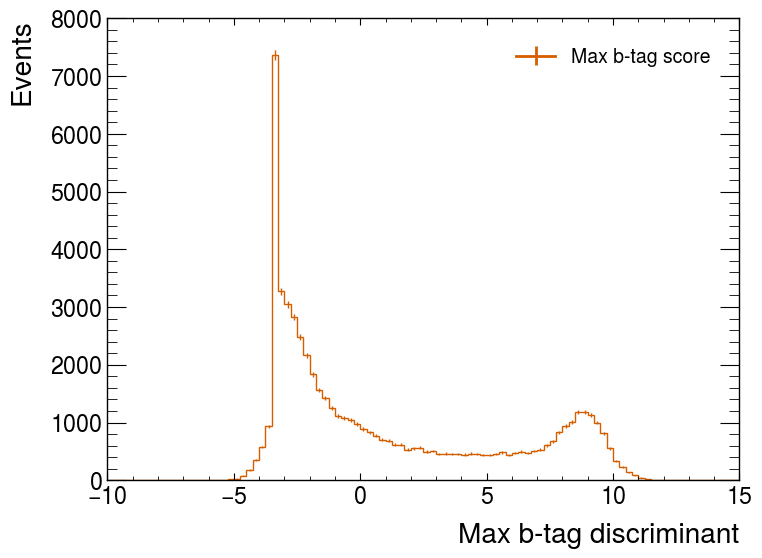

In [80]:
#!/usr/bin/env python3
"""
Fetch jets from a PHYSLITE ttbar all-had dataset via ServiceX,
build all trijet combinations per event, select the one whose
invariant mass is closest to 172.5 GeV, and then plot:

  - the trijet pT
  - the maximum b-tagging discriminant among the three jets

as a 2D histogram saved to a PNG file.
"""

# ---- ServiceX and xAOD tool imports ----
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset

# xAOD tool injection boilerplate (must be copied exactly)
from dataclasses import dataclass
from typing import Callable, Iterable, List, Optional, Tuple, TypeVar
from func_adl import ObjectStream, func_adl_callable
import ast

import numpy as np

T = TypeVar("T")

@dataclass
class ToolInfo:
    name: str

def make_a_tool(
    query: ObjectStream[T],
    tool_name: str,
    tool_type: str,
    include_files: Optional[List[str]],
    init_lines: List[str] = [],
) -> Tuple[ObjectStream[T], ToolInfo]:
    query_base = query.MetaData(
        {
            "metadata_type": "inject_code",
            "name": tool_name,
            "header_includes": include_files,
            "private_members": [f"{tool_type} *{tool_name};"],
            "instance_initialization": [
                f'{tool_name}(new {tool_type} ("{tool_name}"))'
            ],
            "initialize_lines": [l.format(tool_name=tool_name) for l in init_lines],
            "link_libraries": ["xAODBTaggingEfficiencyLib"],
        }
    )
    return query_base, ToolInfo(name=tool_name)

def make_tool_accessor(
    t_info: ToolInfo,
    function_name: str,
    source_code: List[str],
    arguments: Iterable[Tuple[str, type]],
    return_type_cpp: str,
    return_type_python: str
):
    def tool_callback(
        s: ObjectStream[T], a: ast.Call
    ) -> Tuple[ObjectStream[T], ast.Call]:
        new_s = s.MetaData(
            {
                "metadata_type": "add_cpp_function",
                "name": function_name,
                "code": [
                    "double result;",
                    *[l.format(tool_name=t_info.name) for l in source_code],
                ],
                "result": "result",
                "include_files": [],
                "arguments": [a[0] for a in arguments],
                "return_type": return_type_cpp,
            }
        )
        return new_s, a

    def tool_call(**arg_dict):
        ...
    tool_call.__name__ = function_name
    tool_call.__annotations__['return'] = eval(return_type_python)
    return func_adl_callable(tool_callback)(tool_call)

# For b-tagging we need the jet type
from func_adl_servicex_xaodr25.xAOD.jet_v1 import Jet_v1

# ---- Build the ServiceX query ----
# Base on PHYSLITE, filter events with >=3 jets, then retrieve jet kinematics and b-tag weight
base = FuncADLQueryPHYSLITE()

# Inject a BTaggingSelectionTool (FixedCutBEff_77) to compute the tag weight (discriminant)
base, btag_tool = make_a_tool(
    base,
    tool_name="btag_tool",
    tool_type="BTaggingSelectionTool",
    include_files=["xAODBTaggingEfficiency/BTaggingSelectionTool.h"],
    init_lines=[
        'ANA_CHECK(asg::setProperty({tool_name}, "OperatingPoint", "FixedCutBEff_77"));',
        "ANA_CHECK({tool_name}->initialize());",
    ],
)

# Accessor to get the b-tagging discriminant (GNN weight between -10 and 15)
tag_weight = make_tool_accessor(
    btag_tool,
    function_name="tag_weight",
    source_code=["ANA_CHECK({tool_name}->getTaggerWeight(*jet, result, false));"],
    arguments=[("jet", Jet_v1)],
    return_type_cpp="double",
    return_type_python="float",
)

# Name of the Rucio dataset
ds_name = (
    "mc23_13p6TeV:mc23_13p6TeV."
    "601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad.deriv."
    "DAOD_PHYSLITE.e8514_s4369_r16083_p6697"
)

# Build the final query: filter events, then pull out lists of jet pt, eta, phi, mass, and b-tag
query = (
    base
    .Where(lambda e: e.Jets().Count() >= 3)
    .Select(lambda e: {
        "pt":   e.Jets().Select(lambda j: j.pt() / 1000.0),
        "eta":  e.Jets().Select(lambda j: j.eta()),
        "phi":  e.Jets().Select(lambda j: j.phi()),
        "mass": e.Jets().Select(lambda j: j.m() / 1000.0),
        "btag": e.Jets().Select(lambda j: tag_weight(j)),
    })
)

# Fetch just 1 file for testing; remove NFiles for full dataset
samples = [
    Sample(
        Name="jets",
        Dataset=dataset.Rucio(ds_name),
        NFiles=1,
        Query=query,
    )
]

# Execute and convert to Awkward arrays
out = to_awk(deliver(ServiceXSpec(Sample=samples)))
jets = out["jets"]

# ---- Physics & array manipulation ----
import awkward as ak
import vector

# enable Vector behaviors
vector.register_awkward()

# Build an Awkward array of Lorentz vectors for each jet
jet_vecs = ak.zip(
    {
        "pt":  jets["pt"],
        "eta": jets["eta"],
        "phi": jets["phi"],
        "mass": jets["mass"],
    },
    with_name="Momentum4D",
)

# Combine kinematics and btag into one record array
jets_struct = ak.zip({"vec": jet_vecs, "btag": jets["btag"]})

# Build all 3-jet combinations per event
trijets = ak.combinations(jets_struct, 3, fields=["j1", "j2", "j3"], axis=1)

# Sum the 4-vectors to get each trijet's 4-momentum
p4 = trijets.j1.vec + trijets.j2.vec + trijets.j3.vec

# Compute invariant mass and pT for each trijet
m = p4.mass
pt = p4.pt

# Find the trijet whose mass is closest to 172.5 GeV
delta = abs(m - 172.5)
# get index of the best combination per event
idx = ak.argmin(delta, axis=1, keepdims=True)

# Select the best trijet pT and b-tag value, then flatten to 1D
best_pt = ak.flatten(pt[idx])
best_trijets = ak.flatten(trijets[idx])

# Compute max b-tag discriminant per trijet
bvals = np.stack(
    [best_trijets.j1.btag, best_trijets.j2.btag, best_trijets.j3.btag], axis=-1
)
max_b = ak.max(bvals, axis=-1)

best_btag = max_b

# ---- Histogramming and plotting ----
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.ATLAS)

# 2D histogram: trijet pT vs max b-tag discriminant
h_pt = (
    hist.Hist.new
       .Reg(100, 0, 1500, name="trijet_pt", label="Trijet $p_T$ [GeV]")
       .Int64()
)
h_b = hist.Hist.new.Reg(
    100, -10, 15, name="max_btag", label="Max b-tag discriminant"
).Int64()

h_pt.fill(trijet_pt=best_pt)
h_b.fill(max_btag=best_btag)

plt.style.use(hep.style.ATLAS)

plt.figure()
h_pt.plot(histtype="step", linewidth=1, label="Closest-mass trijet")
plt.xlabel("Trijet $p_T$ [GeV]")
plt.ylabel("Events")
plt.legend()
plt.savefig("trijet_pt.png")

plt.figure()
h_b.plot(histtype="step", linewidth=1, label="Max b-tag score")
plt.xlabel("Max b-tag discriminant")
plt.ylabel("Events")
plt.legend()
plt.savefig("max_btag_discriminant.png")

## 7. Isolated Scalar $p_T$.

Plot the scalar sum in each event of the pT of jets with pT > 30 GeV that are not within 0.4 in ΔR of any light lepton with pT > 10 GeV in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad.deriv.DAOD_PHYSLITE.e8514_s4369_r16083_p6697.

* It did the jet cut every-time rather than put it in one central place (which it would have been nice to have since the cut is the same for multiple leaves).
* It used `python` `list` data structures, and not awkward arrays!! Ops!!! But it did work.
* Tried running it again, and it produced another solution (with no prompt change).
  * It asked for bank names for `Electrons`, etc., rather than using the defaults.
  * Tried to use `ak.map`, which does not exist - so this never worked!

In [ ]:
#!/usr/bin/env python

import awkward as ak
import vector
from hist import Hist
import matplotlib.pyplot as plt
import mplhep as hep

from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex import deliver, ServiceXSpec, Sample, dataset
from servicex_analysis_utils import to_awk

# Enable Vector behaviors on Awkward arrays
vector.register_awkward()

# --------------------------------------------------------------------------------
# 1) Build a FuncADL query to
#    - select jets with pT > 30 GeV
#    - select light leptons (e, μ) with pT > 10 GeV
#    - keep their pt, eta, phi (converted to GeV for pt)
# --------------------------------------------------------------------------------
base = FuncADLQueryPHYSLITE()
query = (
    base
    .Select(lambda e: {
        "jet_pt":  e.Jets()
                      .Where(lambda j: j.pt() / 1000.0 > 30.0)
                      .Select(lambda j: j.pt() / 1000.0),
        "jet_eta": e.Jets()
                      .Where(lambda j: j.pt() / 1000.0 > 30.0)
                      .Select(lambda j: j.eta()),
        "jet_phi": e.Jets()
                      .Where(lambda j: j.pt() / 1000.0 > 30.0)
                      .Select(lambda j: j.phi()),
        "ele_pt":  e.Electrons()
                      .Where(lambda el: el.pt() / 1000.0 > 10.0)
                      .Select(lambda el: el.pt() / 1000.0),
        "ele_eta": e.Electrons()
                      .Where(lambda el: el.pt() / 1000.0 > 10.0)
                      .Select(lambda el: el.eta()),
        "ele_phi": e.Electrons()
                      .Where(lambda el: el.pt() / 1000.0 > 10.0)
                      .Select(lambda el: el.phi()),
        "mu_pt":   e.Muons()
                      .Where(lambda mu: mu.pt() / 1000.0 > 10.0)
                      .Select(lambda mu: mu.pt() / 1000.0),
        "mu_eta":  e.Muons()
                      .Where(lambda mu: mu.pt() / 1000.0 > 10.0)
                      .Select(lambda mu: mu.eta()),
        "mu_phi":  e.Muons()
                      .Where(lambda mu: mu.pt() / 1000.0 > 10.0)
                      .Select(lambda mu: mu.phi()),
    })
)

# --------------------------------------------------------------------------------
# 2) Fetch the data via ServiceX (start with 1 file for testing)
# --------------------------------------------------------------------------------
ds_name = (
    "mc23_13p6TeV:"
    "mc23_13p6TeV.601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad."
    "deriv.DAOD_PHYSLITE.e8514_s4369_r16083_p6697"
)

service_x_spec = ServiceXSpec(
    Sample=[
        Sample(
            Name="jet_lep_fetch",
            Dataset=dataset.Rucio(ds_name),
            NFiles=1,
            Query=query,
        )
    ]
)

# This returns a dict of Awkward arrays, keyed by Sample.Name
awk_data = to_awk(deliver(service_x_spec))
events = awk_data["jet_lep_fetch"]

# --------------------------------------------------------------------------------
# 3) Build Vector-aware Awkward arrays for jets and leptons
# --------------------------------------------------------------------------------
jets = ak.zip({
    "pt" : events.jet_pt,
    "eta": events.jet_eta,
    "phi": events.jet_phi,
    "mass": ak.zeros_like(events.jet_pt),
}, with_name="Momentum4D")

electrons = ak.zip({
    "pt" : events.ele_pt,
    "eta": events.ele_eta,
    "phi": events.ele_phi,
    "mass": ak.zeros_like(events.ele_pt),
}, with_name="Momentum4D")

muons = ak.zip({
    "pt" : events.mu_pt,
    "eta": events.mu_eta,
    "phi": events.mu_phi,
    "mass": ak.zeros_like(events.mu_pt),
}, with_name="Momentum4D")

# combine electrons and muons into a single 'light leptons' array per event
leptons = ak.concatenate([electrons, muons], axis=1)

# --------------------------------------------------------------------------------
# 4) Remove any jet closer than ΔR < 0.4 to any light lepton
# --------------------------------------------------------------------------------
# Create a boolean mask per jet: True if ΔR(jet, all_leptons) > 0.4
jet_mask = ak.map(
    lambda jts, lps: ak.Array([
        ak.all(j.deltaR(lps) > 0.4) for j in jts
    ]),
    jets,
    leptons
)

jets_clean = jets[jet_mask]

# --------------------------------------------------------------------------------
# 5) Compute the scalar sum of jet pT in each event
# --------------------------------------------------------------------------------
sum_pt = ak.sum(jets_clean.pt, axis=1)

# --------------------------------------------------------------------------------
# 6) Fill a histogram and plot
# --------------------------------------------------------------------------------
#  - 50 bins from 0 to 1000 GeV
h = (
    Hist.new
    .Reg(50, 0, 1000, name="sum_pt", label="Scalar sum $p_T$ [GeV]")
    .Int64()
)
h.fill(sum_pt=sum_pt)

# ATLAS style plot
plt.style.use(hep.style.ATLAS)
h.plot(histtype="step", label="ttbar all-hadronic")
plt.xlabel("Scalar sum of jet $p_T$ [GeV]")
plt.ylabel("Entries")
plt.legend()
plt.tight_layout()
plt.savefig("sum_pt_scalar_jets.png")
plt.close()

## 8 WZ Production

For events with at least three light leptons, including a same-flavor opposite-charge pair of the leptons, find such a pair that has the invariant mass closest to 91.2 GeV in each event and plot the transverse mass of the system consisting of the missing transverse momentum and the highest-pT light lepton not in this pair in the rucio dataset in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.701005.Sh_2214_lllvjj.deriv.DAOD_PHYSLITE.e8543_s4159_r15224_p6697.

* o4-mini
* Again, with the bank names when it should be using defaults for Electrons and Muons
  * Ah, this is because those bank names are in the hint files! Removed them!
* Added `ele_pdg()` for electrons and muons. And then used them to tell the difference between muon and electron later on. Clever, but that won't work!
  * This is a case where it needs to finish this step, figure out what works, and then move onto the next step, as its strategy in the next step is defined by what works in this step.
* Figured out which events were good events (had the lepton pair combos), but forgot to filter `metphi`, etc., by that number.

Output()

c:\Users\gordo\Code\llms\atlas-plot-agent\.venv\Lib\site-packages\awkward\_layout.py:273: ResourceWarning: unclosed <socket.socket fd=2292, family=2, type=1, proto=6, laddr=('192.168.1.163', 63282), raddr=('192.170.241.246', 443)>
  def from_arraylib(
c:\Users\gordo\Code\llms\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


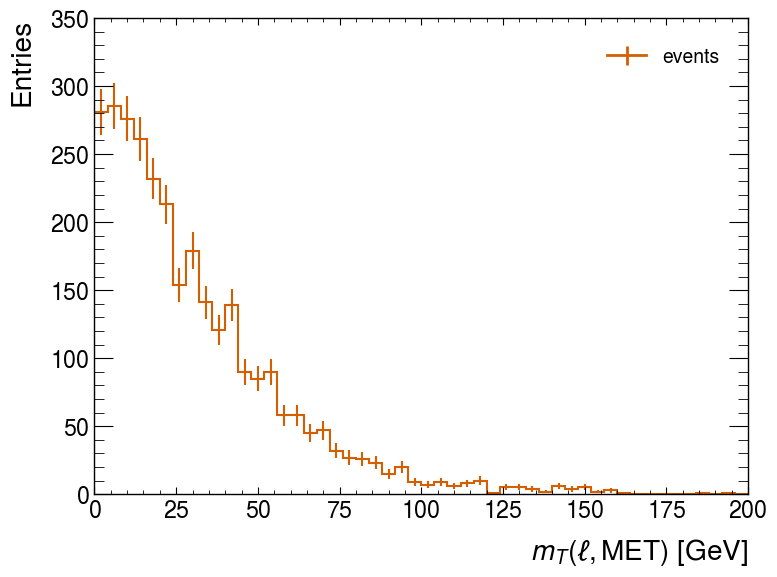

In [131]:
# mt_lep_met.py

import numpy as np
import awkward as ak
import vector
from hist import Hist
import matplotlib.pyplot as plt
import mplhep as hep

# Enable ATLAS style
plt.style.use(hep.style.ATLAS)

# Register vector behaviors on awkward arrays
vector.register_awkward()

# -------------------------------------------------------------------
# STEP 1: Build and run a ServiceX query to fetch leptons and MET
# -------------------------------------------------------------------
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex import deliver, ServiceXSpec, Sample, dataset
from servicex_analysis_utils import to_awk

# Name of the Rucio dataset
ds_name = "mc23_13p6TeV:mc23_13p6TeV.701005.Sh_2214_lllvjj.deriv.DAOD_PHYSLITE.e8543_s4159_r15224_p6697"

# Base query object for PHYSLITE
base = FuncADLQueryPHYSLITE()

# Query: select events with ≥3 light leptons (e or μ), fetch kinematics & charges, and MET
query = (
    base
    # Count electrons + muons with pt>0 to require ≥3 leptons
    .Where(lambda e: e.Electrons().Count() + e.Muons().Count() >= 3).Select(
        lambda e: {
            # ELECTRONS
            "ele_pt": e.Electrons().Select(lambda x: x.pt() / 1000.0),
            "ele_eta": e.Electrons().Select(lambda x: x.eta()),
            "ele_phi": e.Electrons().Select(lambda x: x.phi()),
            "ele_m": e.Electrons().Select(lambda x: x.m()),
            "ele_q": e.Electrons().Select(lambda x: x.charge()),
            "ele_pdg": e.Electrons().Select(lambda x: 1),
            # MUONS
            "mu_pt": e.Muons().Select(lambda x: x.pt() / 1000.0),
            "mu_eta": e.Muons().Select(lambda x: x.eta()),
            "mu_phi": e.Muons().Select(lambda x: x.phi()),
            "mu_m": e.Muons().Select(lambda x: x.m()),
            "mu_q": e.Muons().Select(lambda x: x.charge()),
            "mu_pdg": e.Muons().Select(lambda x: 2),
            # MISSING ET (take the first MET object)
            "met": e.MissingET().First().met() / 1000.0,
            "met_phi": e.MissingET().First().phi(),
        }
    )
)

# Run the query on ServiceX (use NFiles=1 for a quick test; remove/comment out for full dataset)
spec = ServiceXSpec(
    Sample=[
        Sample(Name="lepmet", Dataset=dataset.Rucio(ds_name), NFiles=1, Query=query)
    ]
)
result = deliver(spec)
data = to_awk(result)["lepmet"]

# -------------------------------------------------------------------
# STEP 2: Build an Awkward array of all leptons per event
# -------------------------------------------------------------------
# Zip electrons into Momentum4D records (vector behavior ignores extra fields)
electrons = ak.zip(
    {
        "pt": data.ele_pt,
        "eta": data.ele_eta,
        "phi": data.ele_phi,
        "mass": data.ele_m,
        "charge": data.ele_q,
        "pdgId": data.ele_pdg,
    },
    with_name="Momentum4D",
)

# Zip muons into Momentum4D records
muons = ak.zip(
    {
        "pt": data.mu_pt,
        "eta": data.mu_eta,
        "phi": data.mu_phi,
        "mass": data.mu_m,
        "charge": data.mu_q,
        "pdgId": data.mu_pdg,
    },
    with_name="Momentum4D",
)

# Concatenate electrons and muons per event
leptons = ak.concatenate([electrons, muons], axis=1)

# -------------------------------------------------------------------
# STEP 3: Find SFOS lepton pair closest to Z mass per event
# -------------------------------------------------------------------
# Build all 2-combinations of leptons in each event
pairs = ak.combinations(leptons, 2, fields=["l1", "l2"], axis=1)

# Select same-flavor, opposite-charge pairs
sfos_mask = (abs(pairs.l1.pdgId) == abs(pairs.l2.pdgId)) & (  # same PDG ID
    (pairs.l1.charge + pairs.l2.charge) == 0
)  # opposite charge
sfos_pairs = pairs[sfos_mask]

# Compute invariant mass of each pair
z_masses = (sfos_pairs.l1 + sfos_pairs.l2).mass

# Find index of the pair with mass closest to 91.2 GeV
delta = abs(z_masses - 91.2)
best_idx = ak.argmin(delta, axis=1, keepdims=True)

# Extract that best pair (one per event)
best_pair = ak.flatten(sfos_pairs[best_idx])
l1_best = best_pair.l1
l2_best = best_pair.l2

# -------------------------------------------------------------------
# STEP 4: Pick the highest-pT lepton NOT in the Z-candidate pair
# -------------------------------------------------------------------
# Build a mask that excludes the two leptons in the best Z pair
mask_not_l1 = (leptons.pt != l1_best.pt) | (leptons.phi != l1_best.phi)
mask_not_l2 = (leptons.pt != l2_best.pt) | (leptons.phi != l2_best.phi)
others = leptons[mask_not_l1 & mask_not_l2]

# From the remaining leptons, pick the one with highest pt
idx_other = ak.argmax(others.pt, axis=1, keepdims=True)
# ERROR happens in this next line - when we flatten these guys, we lose the `None`s in the previous step.
best_other = ak.flatten(others[idx_other])

# -------------------------------------------------------------------
# STEP 5: Compute transverse mass m_T(lep, MET) for each event
# -------------------------------------------------------------------
# MET and its phi
met = data[~ak.is_none(idx_other)].met
metphi = data[~ak.is_none(idx_other)].met_phi

# lepton pt and phi
lpt = best_other.pt
lphi = best_other.phi

# transverse mass definition
mt = np.sqrt(2 * lpt * met * (1 - np.cos(lphi - metphi)))

# -------------------------------------------------------------------
# STEP 6: Fill and plot the histogram of mT
# -------------------------------------------------------------------
h_mt = Hist.new.Reg(
    50, 0, 200, name="mt", label=r"$m_{T}(\ell,\mathrm{MET})$ [GeV]"
).Double()

h_mt.fill(mt)

# Draw
plt.figure()
h_mt.plot(histtype="step", linewidth=1.5, label="events")
plt.xlabel(r"$m_{T}(\ell,\mathrm{MET})$ [GeV]")
plt.ylabel("Entries")
plt.legend()
plt.tight_layout()
plt.savefig("mt_lep_met.png")
plt.show()